In [1]:
import jax.numpy as np
from jax import jacrev
import matplotlib.pyplot as plt

c:\Users\UASAL-OPTICS\anaconda3\envs\jaxenv\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [175]:
# try to make an MFT
def ft_fwd(array):
    return np.fft.fftshift(np.fft.fft2(array,norm='ortho'))

def ft_rev(array):
    return (np.fft.ifft2(array,norm='ortho'))

def fftrange(n, dtype=None):
    """FFT-aligned coordinate grid for n samples."""
    # return np.arange(-n//2, -n//2+n, dtype=dtype)
    return np.arange(-(n//2), -(n//2)+n, dtype=dtype)

def Q_for_sampling(input_diameter, prop_dist, wavelength, output_dx):
    """value of Q for a given output sampling, given input sampling"""
    resolution_element = (wavelength * prop_dist) / (input_diameter)
    return resolution_element / output_dx

def mft(wavefunction, input_dx, prop_dist, wavelength, output_dx, output_samples,dir='forward',return_focal_coords=False):

    dia = wavefunction.shape[0] * input_dx
    Q = Q_for_sampling(dia, prop_dist, wavelength, output_dx)
    Q /= wavefunction.shape[0] / output_samples

    # do the MFT
    m = 1/Q
    Na = wavefunction.shape[0]
    Nb = output_samples

    x,y,u,v = [fftrange(n) for n in (Na,Na,Nb,Nb)]

    if dir == 'forward':
        Eout = np.exp(-2j * np.pi / Na * m * np.outer(y,v).T)
        Ein = np.exp(-2j * np.pi / Na * m * np.outer(x,u))
    elif dir == 'reverse':
        Eout = np.exp(2j * np.pi / Na * m * np.outer(y,v).T)
        Ein = np.exp(2j * np.pi / Na * m * np.outer(x,u))
    
    alpha = 1/(Na*Q)
    norm = alpha/np.sqrt(alpha)
    Ein *= norm
    Eout *= norm

    # execute the MFT
    out = Eout @ wavefunction @ Ein

    if return_focal_coords:
        return out,u,v
    else:
        return out
    
def pupil_sample_to_psf_sample(pupil_sample, samples, wavelength, efl):
    return (efl * wavelength) / (pupil_sample * samples)

def make_xy_grid(diameter,npix):

    x = np.linspace(-diameter/2,diameter/2,npix)
    x,y = np.meshgrid(x,x)

    return x,y

def make_circular_aperture(npix,os=1):

    u = np.linspace(-1,1,npix)
    u,v = np.meshgrid(u,u)

    mask = u**2 + v**2 < 1
    mask = mask.astype(np.float32)

    if os > 1:
        pad_width = int(npix/2*os)
        mask = np.pad(mask,pad_width)
    
    return mask

def make_mft_matrix(array,nsamples_forward,dx_forward):
    """makes mft matrix for 1D transformation

    Parameters
    ----------
    array : numpy.ndarray
        array to transform

    nsamples_forward : int
        number of samples in the ensuing plane

    dx_forward : float
        size of one sample, units of inverse mm
    """

    size = array.shape[0] # works for square arrays

    # we assume normalized pupils, so we can construct the 1d transformation
    u = np.linspace(-1,1,size)

    # configure focal plane sampling
    lim = nsamples_forward / 2 * dx_forward
    k = np.linspace(-lim,lim,nsamples_forward)

    # get the MFT matrix
    M = np.exp(1j*np.outer(u,k))

    return M

def mft_forward(array,nsamples_forward,dx_forward):

    # get the mft
    M_fwd_x = make_mft_matrix(array,nsamples_forward,dx_forward)

    # transform the array
    array_fwd = M_fwd_x @ array @ M_fwd_x.T

    return array_fwd

def spc_optimizer(apodizer):
    
    npix = 128
    apodizer = apodizer.reshape([npix,npix])

    # enforce apodizer constraints
    apodizer = np.abs(apodizer) # must be positive
    # apodizer.at[apodizer > 1.].set(1.) # can't be greater than 1
    # apodizer = apodizer.astype(np.float32)

    aper = make_circular_aperture(npix)

    u = np.linspace(-1,1,npix)
    u,v = np.meshgrid(u,u)

    dh = np.sqrt(u**2 + v**2) < 0.25
    dh = dh * (u > 0.05)
    dh = dh.astype(np.float32)

    # compute psf
    psf = mft_forward(aper*apodizer,npix,5e-1)

    # compute cost
    cost = np.sum(dh*np.abs(psf))**2 / psf.size

    return cost

def super_gaussian(r,sigma=7.5):
    return np.exp(-(r**2 / (2*sigma**2))**8)

def super_gaussian_complement(r,sigma=7.5):
    return 1 - super_gaussian(r,sigma=sigma)

def scalar_vortex_mask(u,v,q=2):
    return np.exp(1j*q*np.arctan2(v,u))

def pad2d(array,Q=2):
    if Q == 1:
        return array
    else:
        current_rad = array.shape[0]/2
        return np.pad(array,int(current_rad*(Q-1)))
    
def unpad2d(array,Q=2):
    """acts like the inverse pad operator, takes data away"""
    if Q == 1:
        return array
    else:
        current_shape = int(array.shape[0]/2) # a radius
        prior_shape = int(current_shape/Q) # a radius

        cropped_array = array[current_shape-prior_shape:current_shape+prior_shape,
                              current_shape-prior_shape:current_shape+prior_shape]
        
        return cropped_array

In [207]:
aper = make_circular_aperture(1024)
os_fft = 8
wvl = 633e-9
fno = 40
epd = 36e-3
airy = 2.44*fno*wvl 
nairy = 2
fov = nairy*airy
output_npix = 1024
psf = mft(wavefunction=aper,
        input_dx=epd/aper.shape[0],
        prop_dist=fno*epd,
        wavelength=wvl,
        output_dx=fov/output_npix, # there are loose factors of 2 somewhere, this 4 should not be here
        output_samples=output_npix)
psf_coarse = ft_fwd(pad2d(aper,Q=os_fft))
coarse_focal_sampling = pupil_sample_to_psf_sample(pupil_sample=epd/aper.shape[0]/os_fft,
                                                   samples=aper.shape[0],
                                                   wavelength=wvl,
                                                   efl=fno*epd)
print(coarse_focal_sampling)
u_coarse = np.linspace(-coarse_focal_sampling * aper.shape[0] / 2, coarse_focal_sampling * aper.shape[0] / 2, aper.shape[0] * os_fft)
u_coarse,v_coarse = np.meshgrid(u_coarse,u_coarse)

0.00020256


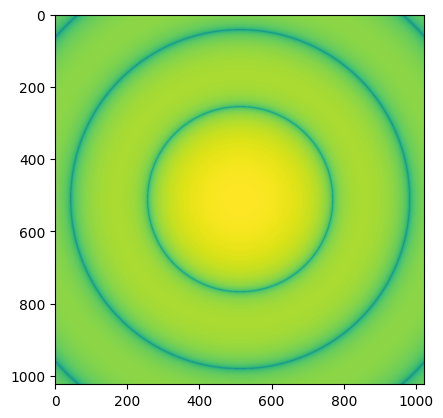

In [208]:
plt.imshow(np.log10(np.abs(psf)))

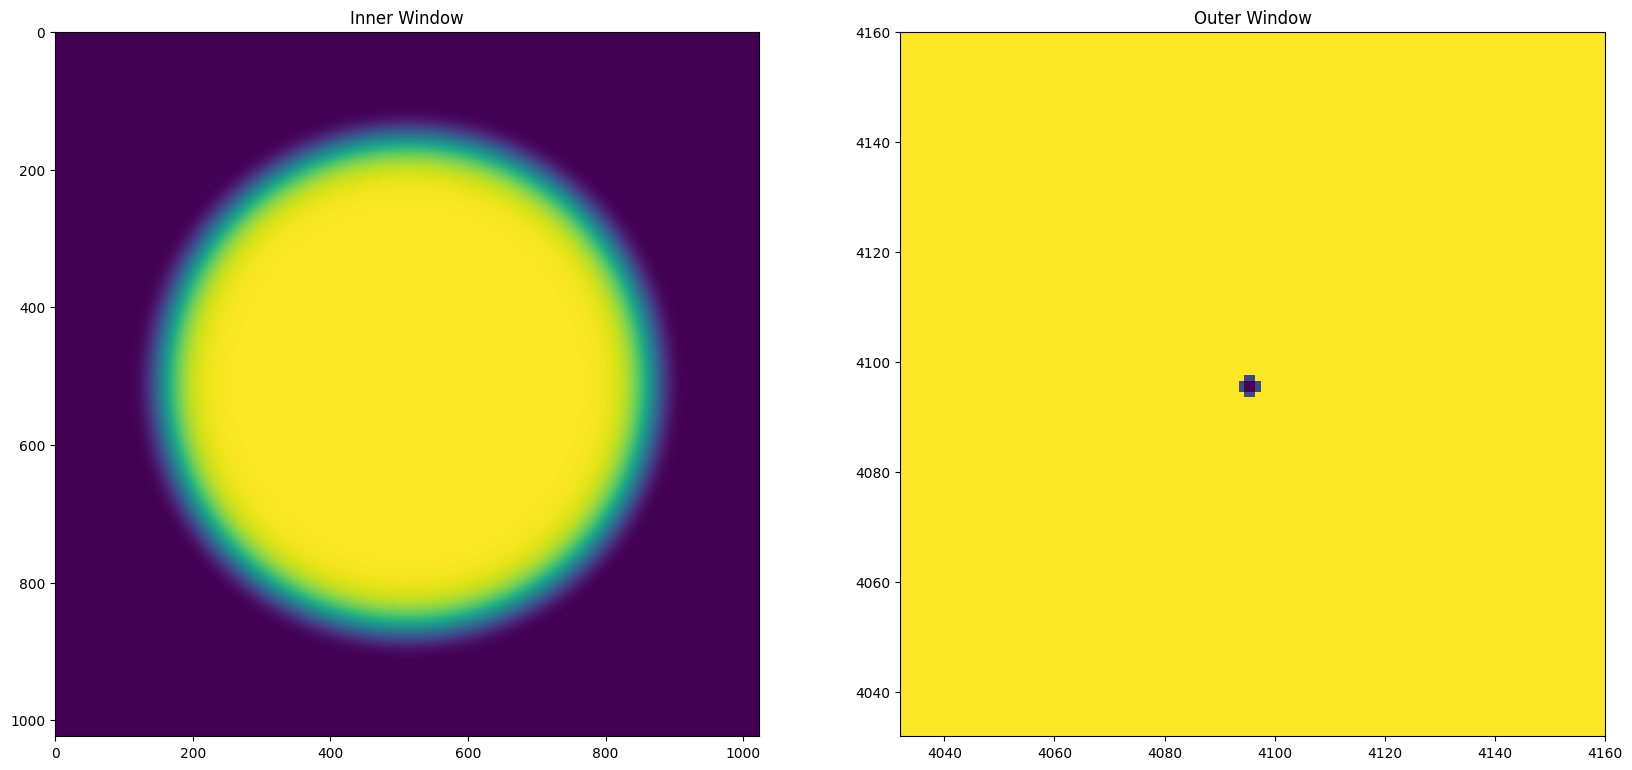

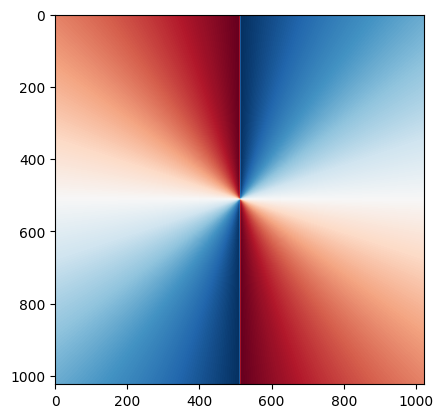

In [210]:
# configure focal coords
u = np.linspace(-fov/2,fov/2,output_npix)
u,v = np.meshgrid(u,u)
rho = np.sqrt(u**2 + v**2)
rho_coarse = np.sqrt(u_coarse**2 + v_coarse**2)
supergauss = super_gaussian(rho,sigma=airy/2)
supergauss_compl = super_gaussian_complement(rho_coarse,sigma=airy/2)

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.title('Inner Window')
plt.imshow(supergauss)
plt.subplot(122)
plt.title('Outer Window')
plt.imshow(supergauss_compl)
cen = rho_coarse.shape[0]/2
cut = 64
plt.xlim(cen-cut,cen+cut)
plt.ylim(cen-cut,cen+cut)
plt.show()

plt.figure()
plt.imshow(np.angle(scalar_vortex_mask(u,v)),cmap='RdBu_r')
plt.show()

In [213]:
# get the two psfs
psf_coro = psf * scalar_vortex_mask(u,v) * super_gaussian(rho,sigma=airy)
psf_coro_coarse = psf_coarse * scalar_vortex_mask(u_coarse,v_coarse) * super_gaussian_complement(rho_coarse,sigma=airy)

# propagate
lyot_coro = mft(psf_coro,
                input_dx=fov/output_npix,
                prop_dist=fno*epd,
                wavelength=wvl,
                output_dx=epd/aper.shape[0], # there are loose factors of 2 somewhere, this 4 should not be here
                output_samples=aper.shape[0],
                dir='reverse')

lyot_coro_coarse = ft_rev(psf_coro_coarse)


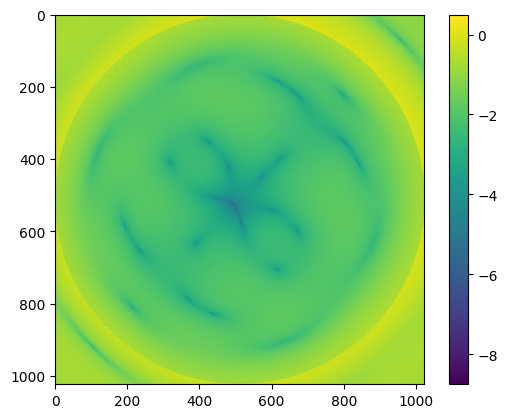

In [214]:
plt.imshow(np.log10(np.abs(lyot_coro + unpad2d(lyot_coro_coarse,Q=os_fft))**2))
plt.colorbar()

In [160]:
import numpy as tnp
spc_optimizer_rev(tnp.random.random([256,256]))

NameError: name 'spc_optimizer_rev' is not defined

In [ ]:
from jax.scipy.optimize import minimize

In [81]:
results = minimize(spc_optimizer,x0=tnp.random.random([128,128]).ravel(),method='BFGS')

c:\Users\UASAL-OPTICS\anaconda3\envs\jaxenv\lib\site-packages\jax\_src\numpy\lax_numpy.py:2071: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "eye")


In [1]:
results.x

NameError: name 'results' is not defined